In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pre_processing import pre_processing,re_sampling,moving_avg
from rejectBlink_PCA import rejectBlink_PCA
import json
import os
from pixel_size import pixel_size,pixel2angle
import warnings
import matplotlib.patches as patches
import pandas as pd
from makeEyemetrics import makeMicroSaccade,draw_heatmap
from zeroInterp import zeroInterp
from tqdm import tqdm

# from scipy.stats import gamma
# import scipy.stats as stats

warnings.simplefilter('ignore')
%matplotlib widget

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
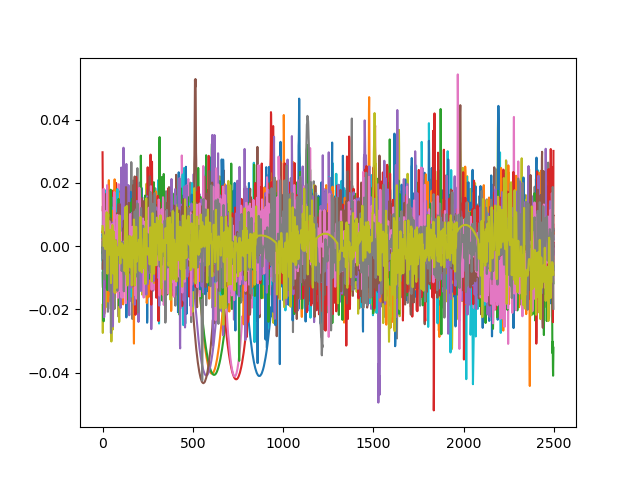

In [2]:
#%% ###  initial settings ###################
cfg={
'SAMPLING_RATE':500,   
'center':[1920, 1080],  
'DOT_PITCH':0.369,   
'VISUAL_DISTANCE':80,   
'acceptMSRange':2.81,
'windowL':10,
'TIME_START':-1,
'TIME_END':4,
'WID_ANALYSIS':4,
'WID_BASELINE':np.array([-0.2,0]),
'WID_FILTER':np.array([]),
'METHOD':1, #subtraction
'FLAG_LOWPASS':False,
'THRES_DIFF':0.04
}

saveFileLocs = './data/'

f = open(os.path.join(str('./data/data_original.json')))
dat = json.load(f)
f.close()

mmName = list(dat.keys())

# v = np.diff(np.array(dat['PDR'])).reshape(-1)
# plt.hist(v,bins=100)
# sigma = np.nanstd(v)
# ramda = 6
# upsilon = ramda*sigma
   
y,rejectNum = pre_processing(np.array(dat['PDR']),cfg)
y = np.delete(y,rejectNum,axis=0)

for mm in mmName:
    dat[mm] = [d for i,d in enumerate(dat[mm]) if not i in rejectNum]

Text(0, 0.5, 'Changes in pupil size')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
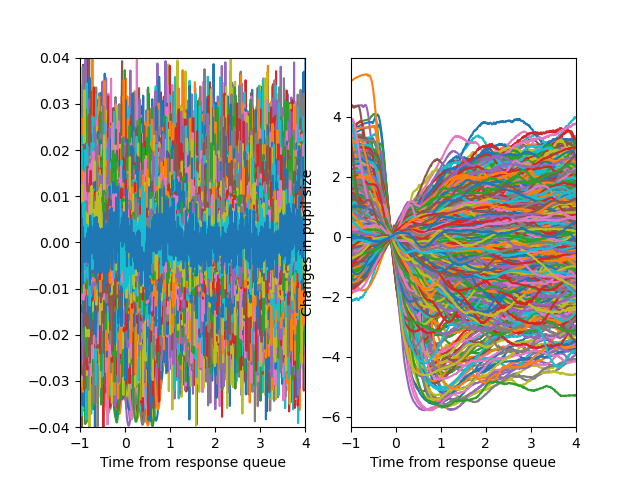

In [3]:
#%% ###  figure plot ##########################
x = np.linspace(cfg['TIME_START'],cfg['TIME_END'],y.shape[1])

plt.figure()
x = np.linspace(cfg['TIME_START'],cfg['TIME_END'],y.shape[1]-1)
plt.subplot(1,2,1)
plt.plot(x,np.diff(y).T)
plt.xlim([cfg['TIME_START'],cfg['TIME_END']])
plt.ylim([-cfg['THRES_DIFF'] ,cfg['THRES_DIFF'] ])
plt.xlabel('Time from response queue')

x = np.linspace(cfg['TIME_START'],cfg['TIME_END'],y.shape[1])

plt.subplot(1,2,2)
plt.plot(x,y.T)
plt.xlim([cfg['TIME_START'],cfg['TIME_END']])
plt.xlabel('Time from response queue')
plt.ylabel('Changes in pupil size')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3004/3004 [00:02<00:00, 1208.61it/s]


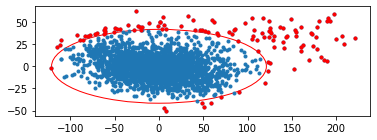

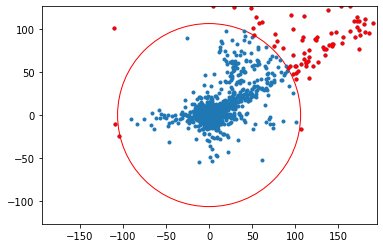

In [4]:
#%% ###  PCA ##########################
pc,rejectNumPCA = rejectBlink_PCA(y)
y = np.delete(y,rejectNumPCA,axis=0)
for mm in mmName:
    dat[mm] = [d for i,d in enumerate(dat[mm]) if not i in rejectNumPCA]

#%% ###  rejection of outlier(interplation failed trial) #########
# max_val = [max(abs(y[i,])) for i in np.arange(y.shape[0])]
# fx = np.diff(y)
# rejectOutlier = []
# for i in np.arange(len(y)):
#     if len(np.unique(np.round(fx[i,],5))) < 20:
#         rejectOutlier.append(i)
 
# y = np.delete(y,rejectOutlier,axis=0)
# for mm in mmName:
#     dat[mm] = [d for i,d in enumerate(dat[mm]) if not i in rejectOutlier]
         
#%% ### reject gaze position ###

gazeX = np.array(dat['gazeX'])
gazeY = np.array(dat['gazeY'])

gazeX = zeroInterp(gazeX.copy(),cfg['SAMPLING_RATE'],5)
gazeX = gazeX['pupilData'][:,cfg['SAMPLING_RATE']:]

gazeY = zeroInterp(gazeY.copy(),cfg['SAMPLING_RATE'],5)
gazeY = gazeY['pupilData'][:,cfg['SAMPLING_RATE']:]

gv = [list(np.gradient(g)*cfg['SAMPLING_RATE']) for g in gazeX.tolist()]
gacc = [list(np.gradient(np.gradient(g))*(cfg['SAMPLING_RATE']**2)) for g in gazeX.tolist()]

thFix = pixel_size(cfg['DOT_PITCH'],30,cfg['VISUAL_DISTANCE'])  # changes in velocity of x > 30°/sec
thAccFix = thFix*400   # changes in acceration of x > 1200°/sec

endFix = []
for iTrial,d in enumerate(tqdm(dat['endFix'])):
    # if len(d)==0:
    sigma = np.std(gv[iTrial])
    sigma = sigma*3
    
    sigma_acc = np.std(gacc[iTrial])
    sigma_acc = sigma_acc*3
    
    ind = np.argwhere(abs(np.array(gv[iTrial])) > sigma).reshape(-1)
    ind_acc = np.argwhere(abs(np.array(gacc[iTrial])) > sigma_acc).reshape(-1)
    # ind_acc = ind_acc[np.argwhere(np.diff(np.r_[0, ind_acc]) > 10)].reshape(-1)
    # ind = np.unique(np.r_[ind,ind_acc])
    if len(ind) > 0:
        if np.max(np.diff(np.r_[0, ind])) > 1:
            eFixTime = ind[np.argwhere(np.diff(np.r_[0, ind]) > 10)].reshape(-1)
            if len(eFixTime) == 0:
                eFixTime = ind[0]
            eFixTime = np.r_[eFixTime,len(gv[iTrial])]
        
            sFixTime = ind[np.r_[np.argwhere(np.diff(np.r_[0, ind]) > 10)[1:].reshape(-1)-1,len(ind)-1]]
            sFixTime = np.r_[0,sFixTime]
            
            tmp_endFix = []
            for iFix in np.arange(len(sFixTime)):
                tmp_endFix.append([0,0,0,
                                   gazeX[iTrial,np.arange(sFixTime[iFix],eFixTime[iFix])].mean(),
                                   gazeY[iTrial,np.arange(sFixTime[iFix],eFixTime[iFix])].mean(),
                                   0])
        else:
            sFixTime = ind[0].tolist()
            eFixTime = ind[-1].tolist()
            tmp_endFix.append([0,0,0,
                          gazeX[iTrial,np.arange(sFixTime,eFixTime)].mean(),
                          gazeY[iTrial,np.arange(sFixTime,eFixTime)].mean(),
                          0])
            
        dat['endFix'][iTrial] = tmp_endFix
    else:
        dat['endFix'][iTrial] = []
        # endFix.append(tmp_endFix)
    
rangeWin = pixel_size(cfg['DOT_PITCH'],cfg['acceptMSRange'],cfg['VISUAL_DISTANCE'])
center = np.array(cfg['center'])/2

gazeX = []
gazeY = []
for iTrial,fixTrial in enumerate(dat['endFix']):
    tmp_gx=[]
    tmp_gy=[]
    if len(fixTrial)>0:
        for gx in fixTrial:
            tmp_gx.append(float(gx[3]))
            tmp_gy.append(float(gx[4]))
        gazeX.append(np.mean(tmp_gx))
        gazeY.append(np.mean(tmp_gy))
    else:
        gazeX.append(0)
        gazeY.append(0)
        
gazeX = np.array(gazeX)-np.array(dat['gazeX']).mean(axis=1)
gazeY = np.array(gazeY)-np.array(dat['gazeY']).mean(axis=1)

# gazeX_p = np.array(gazeX)-center[0]
# gazeY_p = np.array(gazeY)-center[1]

# gazeX_p=pixel2angle(cfg['DOT_PITCH'],gazeX_p.tolist(),cfg['VISUAL_DISTANCE'])
# gazeY_p=pixel2angle(cfg['DOT_PITCH'],gazeY_p.tolist(),cfg['VISUAL_DISTANCE'])

# gazeX = np.mean(gazeX-center[0],axis=1)
# gazeY = np.mean(gazeY-center[1],axis=1)

a = rangeWin**2
b = rangeWin**2

tmp_x = gazeX**2
tmp_y = gazeY**2

P = (tmp_x/a)+(tmp_y/b)-1

rejectGaze = np.argwhere(P > 0).reshape(-1)
    
fig = plt.figure()
ax = plt.axes()
e = patches.Ellipse(xy=(0,0), width=rangeWin*2, height=rangeWin*2, fill=False, ec='r')
ax.add_patch(e)
plt.plot(gazeX,gazeY,'.')
plt.plot(gazeX[rejectGaze],gazeY[rejectGaze],'r.')
plt.axis('equal')
plt.xlim([-rangeWin-20,rangeWin+20])
plt.ylim([-rangeWin-20,rangeWin+20])

rejectGaze2 = np.argwhere(np.isnan(gazeX)).reshape(-1)
rejectGaze = np.unique(np.r_[rejectGaze,rejectGaze2])

y = np.delete(y,rejectGaze,axis=0)
for mm in mmName:
    dat[mm] = [d for i,d in enumerate(dat[mm]) if not i in rejectGaze]

dat['PDR'] = y.tolist()

# of trials = [56, 140, 148, 146, 146, 148, 146, 116, 149, 142, 141, 120, 148, 150, 140, 149, 36, 150, 150, 149, 140]
Averaged # of trials = 133.81
SD # of trials = 29.99
rejected subject = [1, 17]
rejected num ave = 0.046, sd = 0.062


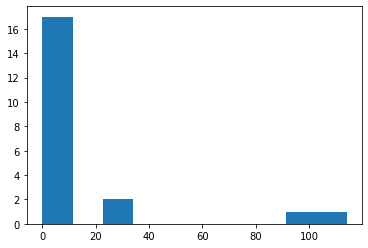

In [5]:
#%% ### participants reject ###
reject=[]
NUM_TRIAL = 150
numOftrials = []
rejectedTrial = []
for iSub in np.arange(1,int(max(dat['sub']))+1):
    ind = [i for i, sub in enumerate(dat['sub']) if sub == iSub]
    numOftrials.append(len(ind))
    rejectedTrial.append(NUM_TRIAL - len(ind))
    if numOftrials[iSub-1] < NUM_TRIAL * 0.5:
            reject.append(iSub)
            
print('# of trials = ' + str(numOftrials))
print('Averaged # of trials = ' + str(np.round(np.mean(numOftrials),2)))
print('SD # of trials = ' + str(np.round(np.std(numOftrials),2)))

n, bins, patches = plt.hist(np.array(rejectedTrial))
# a_hat, loc_hat, scale_hat = gamma.fit(n)
# ps_hat = stats.gamma.pdf(bins, a_hat, loc=loc_hat, scale=scale_hat)

# plt.figure()
# plt.plot(ps_hat)

th = np.round(np.std(rejectedTrial),2)
# np.round(np.median(rejectedTrial),2)

# for iSub in np.arange(1,int(max(dat['sub']))+1):
#     if rejectedTrial[iSub-1] > th:
#         reject.append(iSub)


rejectSub = [i for i,d in enumerate(dat['sub']) if d in reject]
print('rejected subject = ' + str(reject))

y = np.delete(y,rejectSub,axis=0)
for mm in mmName:
    dat[mm] = [d for i,d in enumerate(dat[mm]) if not i in rejectSub]

rejectedTrial = [d for i,d in enumerate(rejectedTrial) if not i+1 in reject]

ave = np.array(rejectedTrial)/NUM_TRIAL
print('rejected num ave = ' + str(round(np.mean(ave),3)) + ', sd = ' + str(round(np.std(ave),3)))



The MPCL was = 0.731s, sd = 0.351s


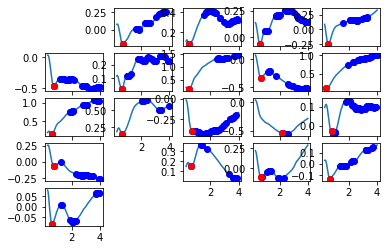

In [6]:
#%% PC events -------------------------------------------
events = {'sub':[],
          'condition':[],
          'PDR':[],
          'min':[]
          }

for iSub in np.unique(dat['sub']):
    for iCond in np.unique(dat['condition']):
        ind = np.argwhere((dat['sub'] == iSub ) &
                          (dat['condition'] == np.int64(iCond) )).reshape(-1)
        tmp_y = y[ind,:]
        tmp_y = moving_avg(tmp_y, 10)
        tmp_y = tmp_y.mean(axis=0)
        
        events['sub'].append(iSub)
        events['condition'].append(iCond)
        events['PDR'].append(tmp_y.tolist())
  
plt.figure()
time_min = 0.3
time_max = 4
dat['min'] = []
dat['events'] = []
dat['events_p'] = []

x_t = x[np.argwhere((x>time_min) & (x<time_max))]

for iSub in np.unique(dat['sub']):
     ind = np.argwhere((events['sub'] == iSub)).reshape(-1)
     
     tmp_p = np.array(events['PDR'])[ind].mean(axis=0)
     tmp_p = tmp_p[np.argwhere(((x>time_min) & (x<time_max)))]
     
     plt.subplot(5,5,iSub)
     plt.plot(x_t,tmp_p)
     
     t = tmp_p.reshape(-1)
     
     # second-order accurate central differences 
     pv = np.gradient(t)
    
     # find inflection point
     indices = np.where(np.diff(np.sign(pv)))[0]
     # plt.plot(x_t[indices],tmp_p[indices],'bo')  
          
     ev = []
     for itr in np.arange(len(indices)):
         if pv[indices[itr]] - pv[indices[itr]+1] > 0:
             ev.append(1)
         else:
             ev.append(0)
             
     indices = indices[np.argwhere(np.array(ev) == 0).reshape(-1)]
    
     # find inflection point
     xv = np.diff(np.r_[0, indices])
     
     indices = indices[xv > 5]
     
     if np.diff(tmp_p[indices].reshape(-1))[0] < 0:
         indices = indices[1:]
     
     if len(indices)>0:
         dat['events'].append([float(x_t[ind]) for ind in indices.tolist()])
         dat['events_p'].append([float(tmp_p[ind]) for ind in indices.tolist()])
         plt.plot(x_t[indices],tmp_p[indices],'bo')  
         indices = indices[0]
         plt.plot(x_t[indices],tmp_p[indices],'ro')  
         dat['min'].append(float(x_t[indices]))
     else:
         dat['min'].append(0)

     # ind = np.argwhere(np.array(dat['sub']) == iSub).reshape(-1)
     # tmp_y = y[ind,indices:]
     # dat['late'] = []

print('The MPCL was = ' + str(round(np.mean(np.array(dat['min'])),3)) + 
      's, sd = ' + str(round(np.std(np.array(dat['min'])),3)) + 's')



In [7]:
#%% ################## figure plot ##########################
# plt.rcParams["font.size"] = 18
# # 1: top glare, 2: bottom glare, 3: center glare, 4: left glare, 5: right glare; 6: top control, 7: bottom control, 8: center control, 9: left control, 10: right control.
# conditionName = ['glare top' ,'glare bottom','glare center','glare left','glare right',
#                  'control top' ,'control bottom','control center','control left','control left']
# x = np.linspace(cfg['TIME_START'],cfg['TIME_END'],y.shape[1])

# plt.figure(figsize=(20, 6))
# for i in np.arange(2):
#     for j in np.arange(5):
#         cond = i*5+j+1
#         if cond < 6:
#             plt.subplot(1,5,cond)
#         else:
#             plt.subplot(1,5,cond-5)
#         ind = np.argwhere((np.array(dat['condition']) == cond)).reshape(-1)
#         plt.plot(x,np.mean(y[ind,],axis=0),label=conditionName[cond-1])
#         # plt.plot(x,y[ind,].T,alpha=0.2)
                 
# plt.legend(loc='lower right')

# del dat['gazeX'], dat['gazeY']
del dat['numOfTrial'], dat['numOfBlink'],dat['numOfSaccade'],dat['ampOfSaccade']


In [8]:
#%% MS -------------------------------------------
dat['ampOfMS'] = []
dat['sTimeOfMS'] = []
ms_events = []
for iSub in np.unique(dat['sub']):
    ind = np.argwhere(np.array(dat['sub'])==np.int64(iSub)).reshape(-1)
    x = [g for i,g in enumerate(dat['gazeX']) if i in ind]
    y = [g for i,g in enumerate(dat['gazeY']) if i in ind]
    ev,ms,fs = makeMicroSaccade(cfg,x,y)
    dat['ampOfMS'] = dat['ampOfMS'] + ms['ampOfMS']
    dat['sTimeOfMS'] = dat['sTimeOfMS'] + ms['sTimeOfMS']
    ms_events = ms_events+ev

# dat['ampOfMS'] = moving_avg(np.array(dat['ampOfMS']).copy(),fs)
# dat['ampOfMS'] = re_sampling(dat['ampOfMS'] ,(cfg['TIME_END']-cfg['TIME_START'])*int(fs/5)).tolist()

# gazeX = moving_avg(np.array(dat['gazeX']).copy(),cfg['SAMPLING_RATE'])
# gazeX = re_sampling(gazeX,(cfg['TIME_END']-cfg['TIME_START'])*100)

# gazeY = moving_avg(np.array(dat['gazeY']).copy(),cfg['SAMPLING_RATE'])
# gazeY = re_sampling(gazeY,(cfg['TIME_END']-cfg['TIME_START'])*100)

# gazeX_p = np.mean(gazeX-center[0],axis=1)
# gazeY_p = np.mean(gazeY-center[1],axis=1)

In [ ]:
#%% gaze xy -------------------------------------------
gazeX = []
gazeY = []
for fixTrial in dat['endFix']:
    tmp_gx=[]
    tmp_gy=[]
    for gx in fixTrial:
        tmp_gx.append(float(gx[3]))
        tmp_gy.append(float(gx[4]))
    gazeX.append(np.mean(tmp_gx))
    gazeY.append(np.mean(tmp_gy))

gazeX_p = np.array(gazeX)-center[0]
gazeY_p = np.array(gazeY)-center[1]
gazeX_p = pixel2angle(cfg['DOT_PITCH'],gazeX_p.tolist(),cfg['VISUAL_DISTANCE'])
gazeY_p = pixel2angle(cfg['DOT_PITCH'],gazeY_p.tolist(),cfg['VISUAL_DISTANCE'])

dat['gazeX'] = gazeX_p.tolist()
dat['gazeY'] = gazeY_p.tolist()

# plt.figure()
# p = np.array(dat['ampOfMS']).mean(axis=0)
# plt.plot(p)
# plt.plot(np.array(dat['ampOfMS'])[0,])

# t = []
# t.append(dat['endFix'][0]+dat['endFix'][1]+dat['endFix'][2]+dat['endFix'][3]+dat['endFix'][4]+dat['endFix'][5])
# h = draw_heatmap(t, cfg['center'])

# plt.imshow(np.nanmean(np.array(h),axis=0))

# a = moving_avg(np.array(dat['ampOfMS']).copy(),50)
# .tolist()
# plt.figure()
# plt.plot(np.array(dat['ampOfMS'])[0,:])
# plt.plot(a[0,:])

# plt.figure(figsize=(10,10))
# tNum=5
# for i,d in enumerate(ms_events[tNum]):
#     plt.subplot(3,5,i+1)
#     plt.plot(d[-3],d[-2])
#     # np.corrcoef(ms_events[tNum][3][-3],ms_events[tNum][4][-3])[0][1]
#     plt.title(str(d[1])+'_'+d[0])

with open(os.path.join("./data/data20211124_f.json"),"w") as f:
        json.dump(dat,f)
